<a href="https://colab.research.google.com/github/Tam107/BDM/blob/main/EE_%2B_RF_%2B_MLP_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from IPython.display import Image

print("Libraries imported successfully")

Libraries imported successfully


In [13]:
cols_to_keep = [
    'price', 'brand', 'model', 'gearbox', 'kilometer', 'powerPS',
    'yearOfRegistration', 'monthOfRegistration', 'dateCreated',
    'vehicleType', 'fuelType', 'notRepairedDamage'
]
data = pd.read_csv('autos.csv', encoding='latin1', usecols=cols_to_keep)
print("5 dòng đầu tiên của dataset:")
print(data.head())
print("\nThông tin dataset:")
print(data.info())

5 dòng đầu tiên của dataset:
   price vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480         NaN                1993    manuell        0   golf   
1  18300       coupe                2011    manuell      190    NaN   
2   9800         suv                2004  automatik      163  grand   
3   1500  kleinwagen                2001    manuell       75   golf   
4   3600  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen               NaN   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep               NaN   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  
0  2016-03-24 00:00:00  
1  2016-03-24 00:00:00  
2  2016-03-1

In [14]:
# Handle missing values
data['powerPS'] = data['powerPS'].replace(0, np.nan).fillna(data['powerPS'].median())
data['yearOfRegistration'] = data['yearOfRegistration'].replace(0, np.nan).fillna(data['yearOfRegistration'].median())
data['monthOfRegistration'] = data['monthOfRegistration'].replace(0, np.nan).fillna(data['monthOfRegistration'].median())
data['gearbox'] = data['gearbox'].fillna('manual')
data['model'] = data['model'].fillna('unknown')
data['brand'] = data['brand'].fillna('unknown')
data['vehicleType'] = data['vehicleType'].fillna('unknown')
data['fuelType'] = data['fuelType'].fillna('unknown')
data['notRepairedDamage'] = data['notRepairedDamage'].fillna('nein')

# Feature engineering
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
data['car_age'] = data['adYear'] - data['yearOfRegistration']
data['powerPS_per_km'] = data['powerPS'] / (data['kilometer'] + 1)
data['age_km_interaction'] = data['car_age'] * data['kilometer']
data['is_damaged'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0})
data = data.drop(columns=['dateCreated', 'yearOfRegistration', 'notRepairedDamage'])

# Ensure categorical columns are strings
for col in ['brand', 'model', 'gearbox', 'vehicleType', 'fuelType']:
    data[col] = data[col].astype(str)

# Dummies for gearbox
gearbox_dummies = pd.get_dummies(data['gearbox'], prefix='gearbox')
data = pd.concat([data, gearbox_dummies], axis=1).drop('gearbox', axis=1)

# Numeric columns
numeric_cols = [col for col in data.columns if col not in ['price', 'brand', 'model', 'vehicleType', 'fuelType']]

# Filter price > 0
data = data[data['price'] > 0]
print(f"Number of rows after removing price=0: {len(data)}")

# Clip outliers
for col in ['price', 'kilometer', 'powerPS', 'car_age']:
    lower_bound = data[col].quantile(0.01)
    upper_bound = data[col].quantile(0.99)
    print(f"Clipping {col}: lower_bound={lower_bound}, upper_bound={upper_bound}")
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Scale numeric features
scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Scale price
price_scaler = MinMaxScaler()
data['price'] = price_scaler.fit_transform(data[['price']])
print("Price Scaler Parameters:")
print(f"data_min_: {price_scaler.data_min_}")
print(f"data_max_: {price_scaler.data_max_}")

print("\n5 dòng đầu tiên sau khi xử lý:")
print(data.head())
print("\nThông tin dataset sau xử lý:")
print(data.info())

Number of rows after removing price=0: 360750
Clipping price: lower_bound=110.0, upper_bound=36500.0
Clipping kilometer: lower_bound=5000.0, upper_bound=150000.0
Clipping powerPS: lower_bound=45.0, upper_bound=340.0
Clipping car_age: lower_bound=-2.0, upper_bound=37.0
Price Scaler Parameters:
data_min_: [110.]
data_max_: [36500.]

5 dòng đầu tiên sau khi xử lý:
      price vehicleType   powerPS    model  kilometer  monthOfRegistration  \
0  0.010168     unknown  0.203390     golf   1.000000             0.454545   
1  0.499863       coupe  0.491525  unknown   0.827586             0.363636   
2  0.266282         suv  0.400000    grand   0.827586             0.636364   
3  0.038197  kleinwagen  0.101695     golf   1.000000             0.454545   
4  0.095905  kleinwagen  0.081356    fabia   0.586207             0.545455   

  fuelType       brand  adYear   car_age  powerPS_per_km  age_km_interaction  \
0   benzin  volkswagen     1.0  0.641026        0.000199            0.406100   
1   die

In [15]:
X = data.drop(['price'], axis=1).copy()
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f'\nTập huấn luyện có {X_train_new.shape[0]} bản ghi và {X_train_new.shape[1]} cột.')
print(f'Tập validation có {len(X_val)} bản ghi.')
print(f'Tập kiểm tra có {len(X_test)} bản ghi.')


Tập huấn luyện có 230880 bản ghi và 15 cột.
Tập validation có 57720 bản ghi.
Tập kiểm tra có 72150 bản ghi.


In [16]:
# Prepare data for Random Forest with one-hot encoding
X_train_rf = X_train_new.copy()
X_val_rf = X_val.copy()
X_test_rf = X_test.copy()

cat_cols = ['brand', 'model', 'vehicleType', 'fuelType']
X_train_rf = pd.get_dummies(X_train_rf, columns=cat_cols)
X_val_rf = pd.get_dummies(X_val_rf, columns=cat_cols)
X_test_rf = pd.get_dummies(X_test_rf, columns=cat_cols)

# Align columns
X_train_rf, X_val_rf = X_train_rf.align(X_val_rf, join='left', axis=1, fill_value=0)
X_train_rf, X_test_rf = X_train_rf.align(X_test_rf, join='left', axis=1, fill_value=0)
X_val_rf, X_test_rf = X_val_rf.align(X_test_rf, join='left', axis=1, fill_value=0)

# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_rf, y_train_new)

# Generate RF predictions
rf_pred_train = rf.predict(X_train_rf)
rf_pred_val = rf.predict(X_val_rf)
rf_pred_test = rf.predict(X_test_rf)

# Scale RF predictions to [0, 1]
rf_scaler = MinMaxScaler()
rf_pred_train = rf_scaler.fit_transform(rf_pred_train.reshape(-1, 1)).flatten()
rf_pred_val = rf_scaler.transform(rf_pred_val.reshape(-1, 1)).flatten()
rf_pred_test = rf_scaler.transform(rf_pred_test.reshape(-1, 1)).flatten()

# Add RF predictions as a feature
X_train_new['rf_pred'] = rf_pred_train
X_val['rf_pred'] = rf_pred_val
X_test['rf_pred'] = rf_pred_test

# Check for nan/inf in data
print("Checking for NaN in X_train_new:", X_train_new.isna().sum().sum())
print("Checking for NaN in X_val:", X_val.isna().sum().sum())
print("Checking for NaN in y_train_new:", np.isnan(y_train_new).sum())
print("Checking for NaN in y_val:", np.isnan(y_val).sum())
print("Checking for inf in X_train_new:", np.isinf(X_train_new[numeric_cols]).sum().sum())
print("Checking for inf in X_val:", np.isinf(X_val[numeric_cols]).sum().sum())

print(f"Random Forest training data shape: {X_train_rf.shape}")
print(f"Random Forest validation MSE: {np.mean((y_val - rf_pred_val) ** 2):.6f}")
print(f"Random Forest validation MAE: {np.mean(np.abs(y_val - rf_pred_val)):.6f}")

Checking for NaN in X_train_new: 0
Checking for NaN in X_val: 0
Checking for NaN in y_train_new: 0
Checking for NaN in y_val: 0
Checking for inf in X_train_new: 0
Checking for inf in X_val: 0
Random Forest training data shape: (230880, 318)
Random Forest validation MSE: 0.004302
Random Forest validation MAE: 0.034224


In [6]:
input_list_train_new = []
input_list_val = []
input_list_test = []
cat_encoders = {}
for col in ['brand', 'model', 'vehicleType', 'fuelType']:
    unique_cat = np.unique(X_train_new[col])
    cat_encoders[col] = {val: idx for idx, val in enumerate(unique_cat)}
    input_list_train_new.append(X_train_new[col].map(cat_encoders[col]).values.astype(np.int32))
    input_list_val.append(X_val[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    input_list_test.append(X_test[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    print(f'\nCó {len(unique_cat)} giá trị duy nhất trong cột {col} trong tập huấn luyện.')

numeric_cols = [col for col in X_train_new.columns if col not in ['brand', 'model', 'vehicleType', 'fuelType']]
input_list_train_new.append(X_train_new[numeric_cols].values.astype(np.float32))
input_list_val.append(X_val[numeric_cols].values.astype(np.float32))
input_list_test.append(X_test[numeric_cols].values.astype(np.float32))

y_train_new = y_train_new.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)


Có 41 giá trị duy nhất trong cột brand trong tập huấn luyện.

Có 248 giá trị duy nhất trong cột model trong tập huấn luyện.

Có 9 giá trị duy nhất trong cột vehicleType trong tập huấn luyện.

Có 8 giá trị duy nhất trong cột fuelType trong tập huấn luyện.



Tóm tắt mô hình MLP:


Model: "Stacked_RF_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 8)           │            328 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 15)          │          3,720 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 5)           │             45 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 1, 4)           │             32 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 8)              │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 15)             │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 5)              │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 4)              │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 44)             │              0 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0],       │
│                           │                        │                │ reshape_2[0][0],       │
│                           │                        │                │ reshape_3[0][0],       │
│                           │                        │                │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │         23,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 205,598 (803.12 KB)

 Trainable params: 203,678 (795.62 KB)

 Non-trainable params: 1,920 (7.50 KB)

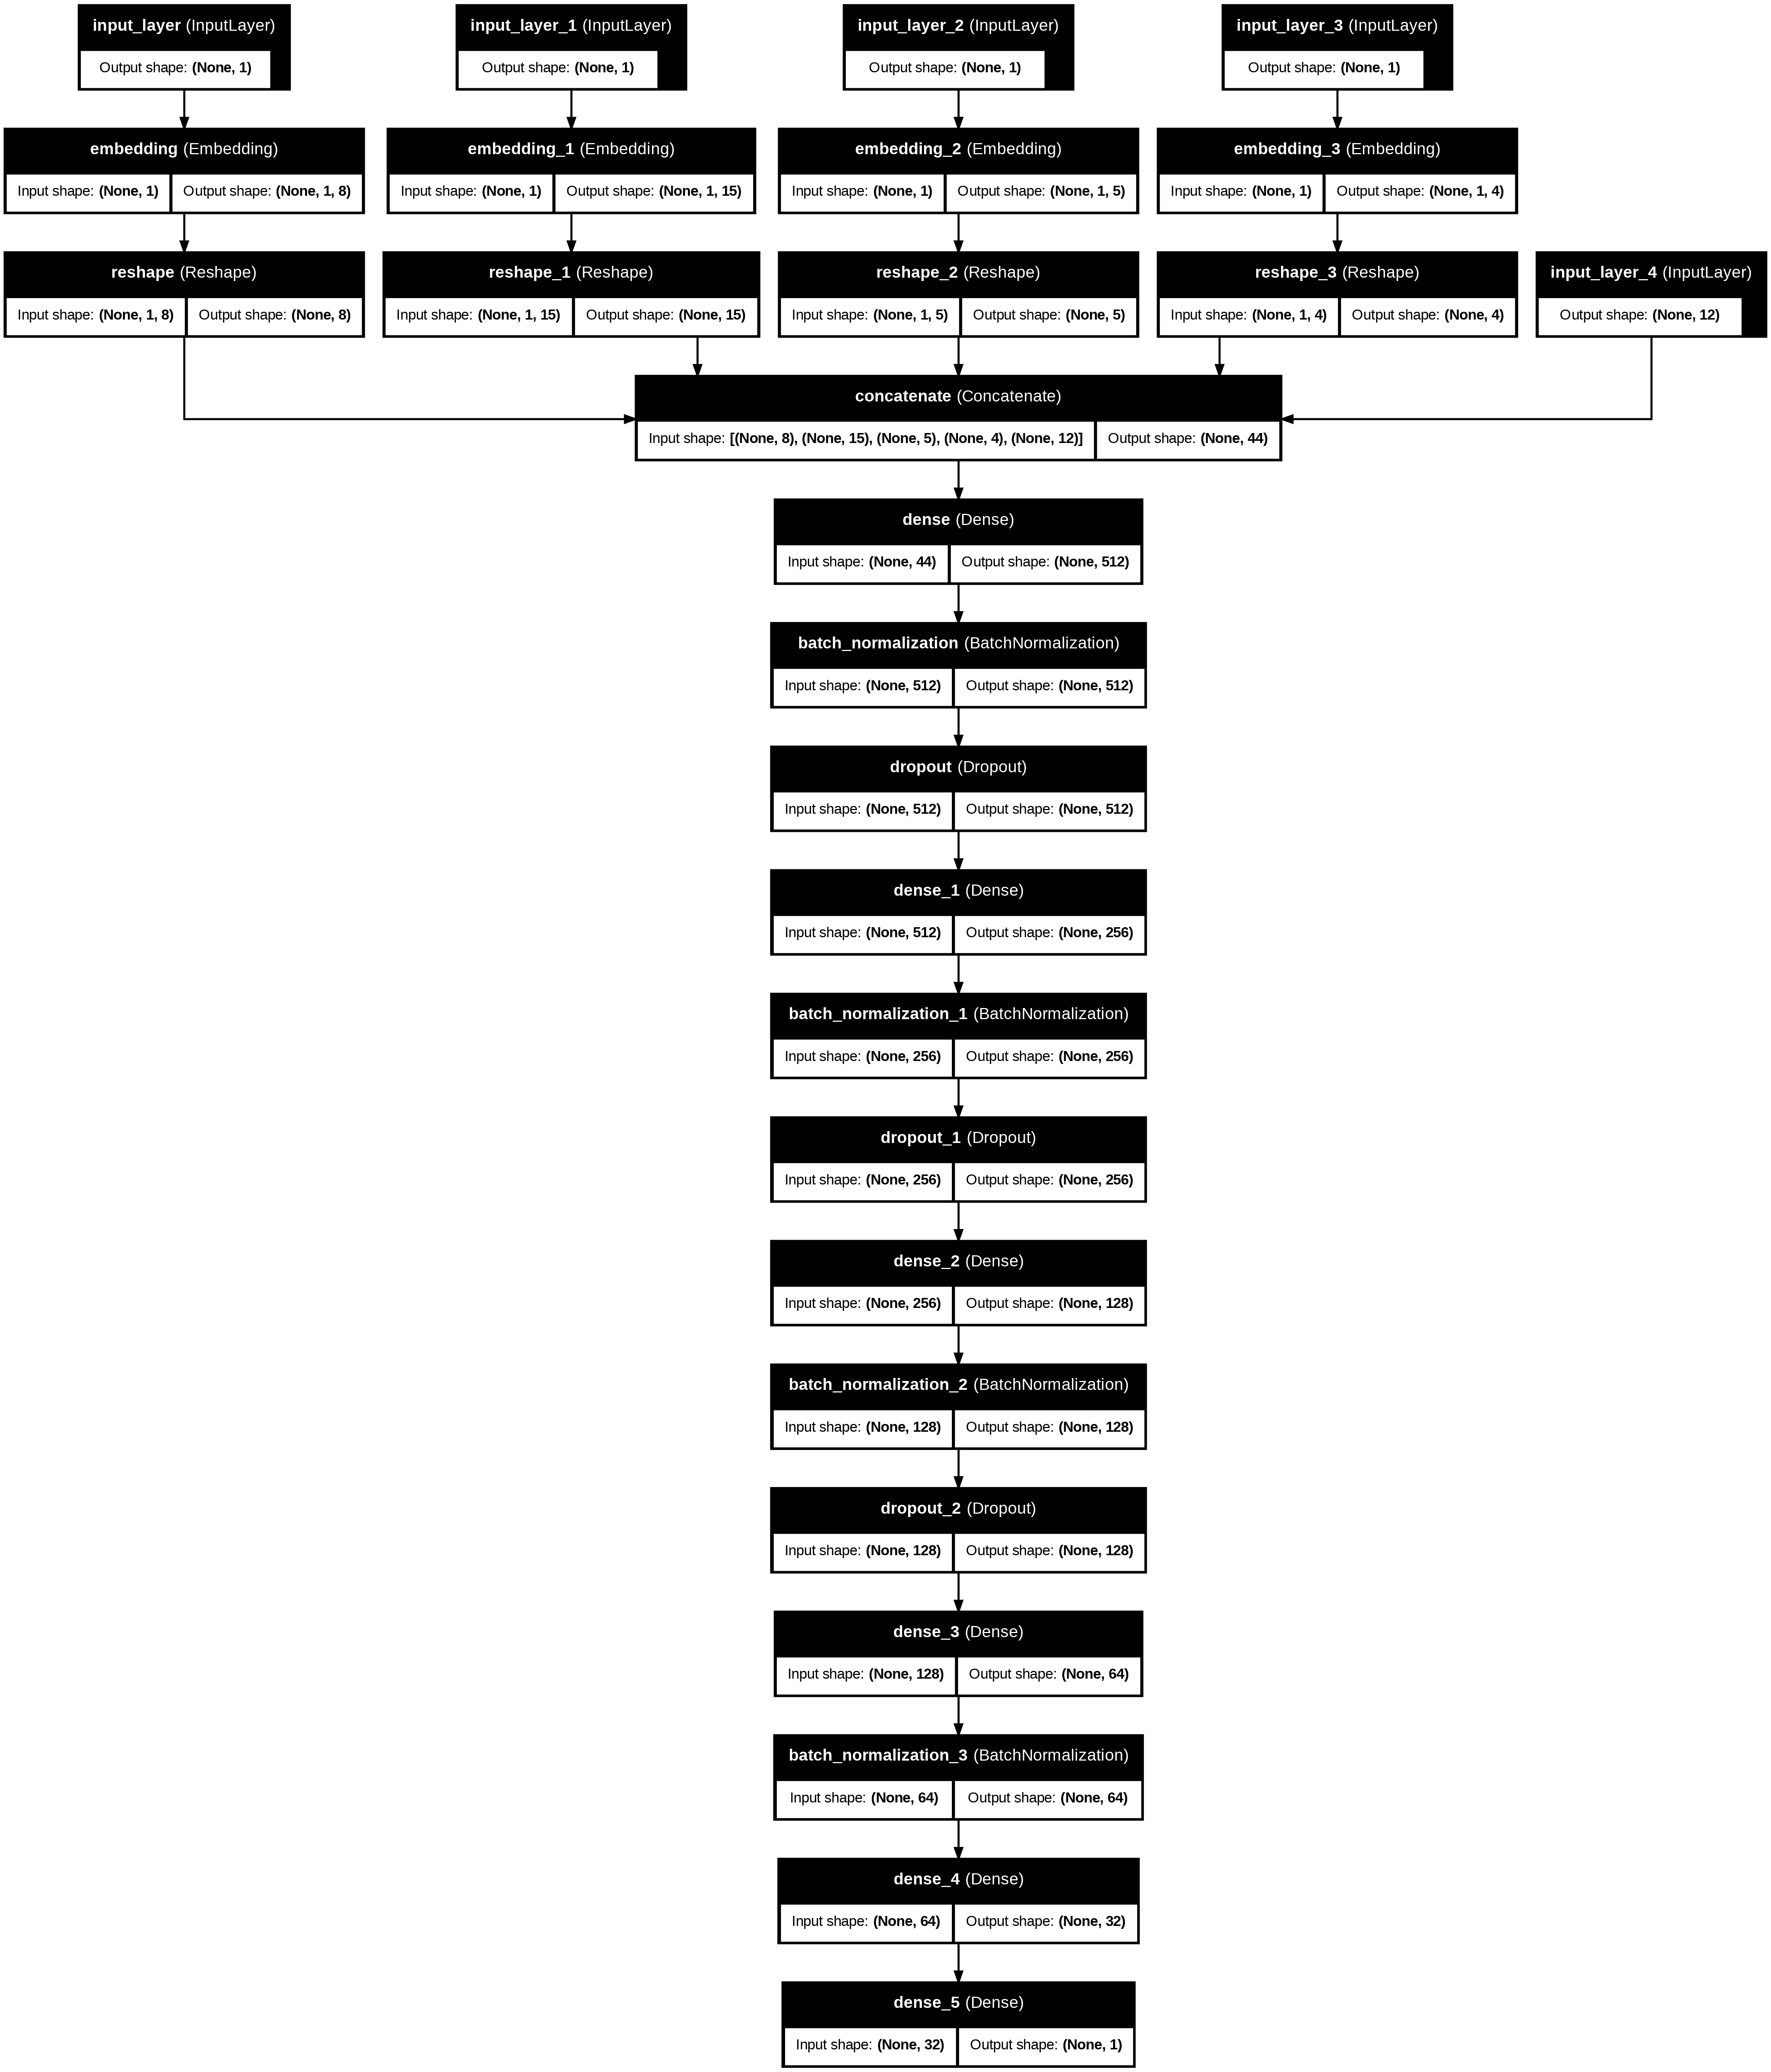

In [7]:
# Define embedding dimensions
n_unique_brand = len(np.unique(X_train_new['brand']))
n_unique_model = len(np.unique(X_train_new['model']))
n_unique_vehicleType = len(np.unique(X_train_new['vehicleType']))
n_unique_fuelType = len(np.unique(X_train_new['fuelType']))

input_brand = Input(shape=(1,))
emb_brand = Embedding(input_dim=n_unique_brand, output_dim=8)(input_brand)
emb_brand = Reshape(target_shape=(8,))(emb_brand)

input_model = Input(shape=(1,))
emb_model = Embedding(input_dim=n_unique_model, output_dim=15)(input_model)
emb_model = Reshape(target_shape=(15,))(emb_model)

input_vehicleType = Input(shape=(1,))
emb_vehicleType = Embedding(input_dim=n_unique_vehicleType, output_dim=5)(input_vehicleType)
emb_vehicleType = Reshape(target_shape=(5,))(emb_vehicleType)

input_fuelType = Input(shape=(1,))
emb_fuelType = Embedding(input_dim=n_unique_fuelType, output_dim=4)(input_fuelType)
emb_fuelType = Reshape(target_shape=(4,))(emb_fuelType)

input_numeric = Input(shape=(len(numeric_cols),))  # Includes rf_pred
emb_numeric = input_numeric

input_data = [input_brand, input_model, input_vehicleType, input_fuelType, input_numeric]
emb_data = [emb_brand, emb_model, emb_vehicleType, emb_fuelType, emb_numeric]

# Concatenate embeddings
model_data = Concatenate()(emb_data)

# Simplified MLP to reduce instability
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(model_data)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation='sigmoid')(x)

nn = Model(inputs=input_data, outputs=outputs, name='Stacked_RF_MLP')
print("\nTóm tắt mô hình MLP:")
nn.summary()
plot_model(nn, show_shapes=True, show_layer_names=True, to_file='Stacked_RF_MLP.png')
Image(retina=True, filename='Stacked_RF_MLP.png')

Epoch 1/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0020
Epoch 2/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0020
Epoch 3/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0020
Epoch 4/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0020
Epoch 5/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0020
Epoch 6/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0010
Epoch 7/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0010
Epoch 8/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: nan - mae: nan - val_loss: na

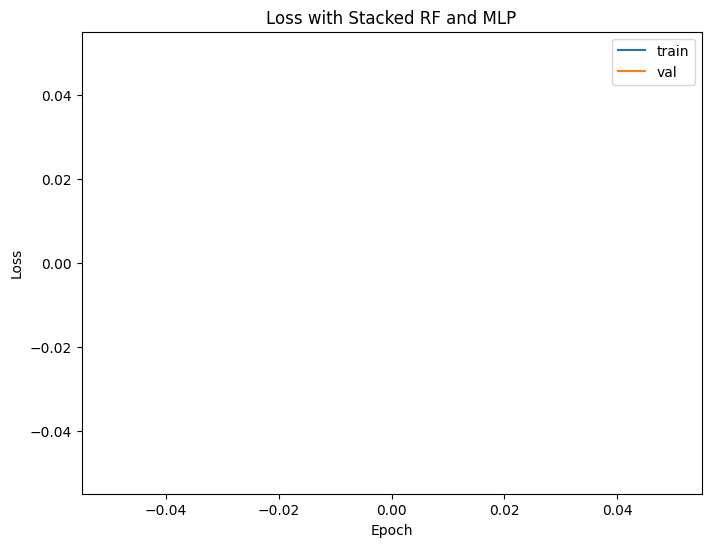

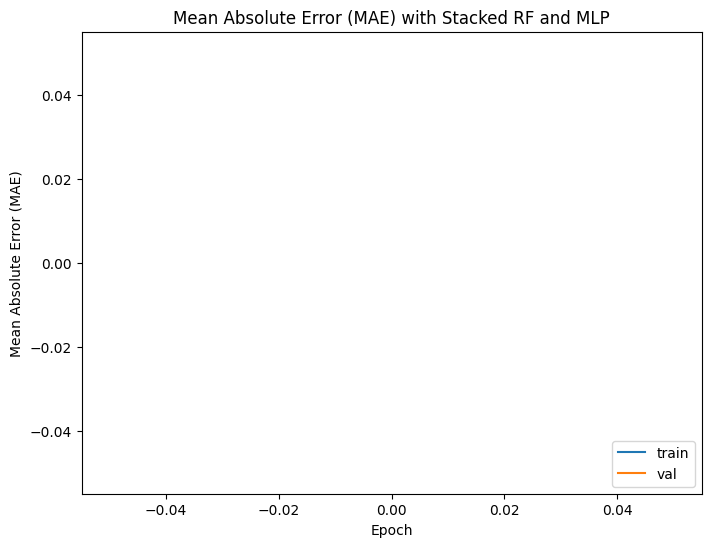

In [8]:
# Compile with gradient clipping
nn.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),  # Lower LR and clip gradients
    metrics=['mae']
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-05)

history = nn.fit(
    input_list_train_new,
    y_train_new,
    validation_data=(input_list_val, y_val),
    epochs=150,
    batch_size=512,
    verbose=1,
    callbacks=[es, lr_scheduler]
)

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss with Stacked RF and MLP')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) with Stacked RF and MLP')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
# MLP predictions
y_test_predict_mlp = nn.predict(input_list_test)
y_test_predict_mlp = np.clip(y_test_predict_mlp, 0, 1)
y_test_predict_mlp = price_scaler.inverse_transform(y_test_predict_mlp).flatten()

# RF predictions (for comparison)
y_test_predict_rf = rf_pred_test
y_test_predict_rf = np.clip(y_test_predict_rf, 0, 1)
y_test_predict_rf = price_scaler.inverse_transform(y_test_predict_rf.reshape(-1, 1)).flatten()

# Inverse transform y_test
y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create results DataFrame
result_df = pd.DataFrame(index=X_test.index, columns=['Random', 'Naive_Mean', 'RF', 'Stacked_MLP', 'Actual'])
result_df['Actual'] = y_test_original
result_df['Naive_Mean'] = price_scaler.inverse_transform([[y_train.mean()]] * len(y_test)).flatten()
result_df['Random'] = price_scaler.inverse_transform(np.random.uniform(y_train.min(), y_train.max(), len(y_test)).reshape(-1, 1)).flatten()
result_df['RF'] = y_test_predict_rf
result_df['Stacked_MLP'] = y_test_predict_mlp

# Calculate metrics
metric_df = pd.DataFrame(index=['MSE', 'RMSE', 'MAE', 'R2', 'MAPE'], columns=['Random', 'Naive_Mean', 'RF', 'Stacked_MLP'])
n_test = len(result_df)

for m in metric_df.columns:
    metric_df.at['MSE', m] = np.sum((result_df['Actual'] - result_df[m])**2) / n_test
    metric_df.at['RMSE', m] = np.sqrt(metric_df.at['MSE', m])
    metric_df.at['MAE', m] = np.sum(abs(result_df['Actual'] - result_df[m])) / n_test
    ss_tot = np.sum((result_df['Actual'] - result_df['Actual'].mean())**2)
    ss_res = np.sum((result_df['Actual'] - result_df[m])**2)
    metric_df.at['R2', m] = 1 - ss_res / ss_tot if ss_tot != 0 else 0
    non_zero_mask = result_df['Actual'] != 0
    metric_df.at['MAPE', m] = np.sum(np.abs(result_df['Actual'][non_zero_mask] - result_df[m][non_zero_mask]) / np.maximum(result_df['Actual'][non_zero_mask], 1000)) / non_zero_mask.sum() * 100

print("Evaluation Metrics:")
print(metric_df)

# Heatmap of absolute errors
for m in ['Random', 'Naive_Mean', 'RF', 'Stacked_MLP']:
    result_df[f'|{m}-Actual|'] = abs(result_df[m] - result_df['Actual'])

table = result_df[['|Random-Actual|', '|Naive_Mean-Actual|', '|RF-Actual|', '|Stacked_MLP-Actual|']]
plt.figure(figsize=(2, 10))
sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
plt.title('Absolute Errors Heatmap')
plt.show()